<a href="https://colab.research.google.com/github/pumazzo/ML-ISS2023/blob/main/Lezione_2_ML_ISS2023_pipeline_supervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduzione al Deep Learning per le Scienze della Salute
## Lezione 2 ***Pipeline supervised***

In questo notebook vedremo:
-  Creazione di sue dataset.
  - "palle" Gaussiane
  - Cerchi concentrici
- Split train / validation / test
- Cross validation
- Applicazione di un modello di apprendimento supervisionato
  - logistic regression
  - k-NN
- Valutazione delle performance
- Proviamo un trucco: feature engineering?


In questo notebook vedremo un semplice problema di classificazione.
Approfittiamo per imparare qualcosa di python e a usare la documentazione.

# Step 1 - Creazione e visualizzazione del dataset 1
 Ripetiamo la creazione del dataset visto in lezione 1

 Suggerimento: per evitare di creare variabili inuti nell'ambiente, cerchiamo di lavorare con delle funzioni
 - Variabili create all'interno di una funzione non sono disponibili all'interno del "notebook" e vengono cancellate appena la funzione termina l'esecuzione.


In [ ]:
# Esempio di una funzione in python (e le sue stranezze)


def funzione_senza_argomenti(): # quando questa funzione viene chiamata restituisce una stringa

  return "sono l'output di una funzione" # return interrompe l'esecuzione di una funzione e restituisce il valore argomento di return

output_funzione = funzione_senza_argomenti()

print(output_funzione)

sono l'output di una funzione


In [ ]:
# una funzione può dipendere da variabili passate come argomenti

def funzione_con_argomenti(valore):
  return "il mio argomento è {}".format(valore)

output_funzione = funzione_con_argomenti(2)

print(output_funzione)

il mio argomento è 2


In [ ]:
# in una funzione si può eseguire codice arbitrario e "return" non è necessario se non si vogliono passare variabili
# in python le funzioni accedono alle variabili definite nel "notebook" ma non viceversa.
#
variabile_definita_fuori = "ML@ISS"

def stampa_stringa():
  stringa= "questa variabile è definita nella funzione, quella sotto no"
  print(stringa)
  print(variabile_definita_fuori)

stampa_stringa()

questa variabile è definita nella funzione, quella sotto no
ML@ISS


In [ ]:
# se riassegniamo una variabile questo non modifica la variabile esterna
def stampa_con_cambio():
  variabile_definita_fuori = "gli cambio valore dentro la funzione"

  print("la variabile cambia solo nella funzione : \n",variabile_definita_fuori)

stampa_con_cambio()

# la variabile originale non è stata toccata

print("la variabile originale è ancora con noi : \n", variabile_definita_fuori)

la variabile cambia solo nella funzione : 
 gli cambio valore dentro la funzione
la variabile originale è ancora con noi : 
 ML@ISS


In [ ]:
# state attenti chè python è infido. Se modifichiamo il contenuto di una variabile questo invece avrà effetto nel notebook.
# tutte queste cose strane sono frutto di un concetto che il passaggio come "copia" o come "riferimento".
#La questione è complicata e a voi non interessa ma il messaggio è che dovete stare attenti

In [ ]:
my_list = ["cane","gatto","topo"]
print(my_list)
def funzione_su_lista(my_list):
  my_list[1]="cammello"


funzione_su_lista(my_list)# eseguo funzione, attenti che perdo il contenuto originale
print(my_list)

# per evitare potete passare un variabile come copia in modo esplicito
my_list = ["cane","gatto","topo"]
print(my_list)
funzione_su_lista(my_list.copy())# eseguo funzione, così sono sicuro
print(my_list)

['cane', 'gatto', 'topo']
['cane', 'cammello', 'topo']
['cane', 'gatto', 'topo']
['cane', 'gatto', 'topo']


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# this function has default values!!!!!

Npoints= 1000
def get_dataset_ball(Npoints ,mu1=np.array([1,1]),  mu2  =np.array([-1,-1]),sigma=0.1):


  D = 2
  cov1 = sigma*np.array([[3, 1], [1, 2]])

  d1 =  np.random.randn(Npoints, D)@ np.linalg.cholesky(cov1) + mu1
  d2 = sigma*np.random.randn(Npoints, D) + mu2

  # concatenate classes
  data= np.concatenate([d1,d2],axis=0)
  labels = np.concatenate([np.zeros(Npoints),np.ones(Npoints)],axis=0)
  print(data.shape)
  print(labels.shape)
  return data, labels

X1, y1 = get_dataset_ball(Npoints)

(2000, 2)
(2000,)


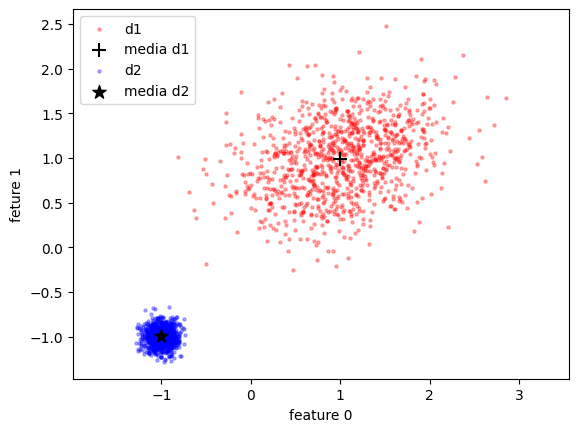

In [ ]:
def plot_dataset(X,y):

  f,ax = plt.subplots(1)
  d1 = X[y==0,:]
  d2 = X[y==1,:]
  ax.scatter(d1[:,0],d1[:,1],s=5,alpha=0.3,color="r",label="d1")
  ax.scatter(d1[:,0].mean(),d1[:,1].mean(),s=100,alpha=1,marker="+",color="k",label="media d1")
  ax.scatter(d2[:,0],d2[:,1],s=5,alpha=0.3,color="b",label="d2")
  ax.scatter(d2[:,0].mean(),d2[:,1].mean(),s=100,alpha=1,marker="*",color="k",label="media d2")
  ax.set_xlabel("feature 0")
  ax.set_ylabel("feture 1")
  ax.axis('equal')
  plt.legend()

plot_dataset(X1,y1)

In [ ]:

def get_dataset_circle(Npoints, sigma=0.5):
  # Radius of the inner circle (class 0)
  radius_inner_circle = 2

  # Radius of the outer circle (class 1)
  radius_outer_circle = 5

  # Generate random angles for the circles
  theta_inner_circle = 2 * np.pi * np.random.rand(Npoints)
  theta_outer_circle = 2 * np.pi * np.random.rand(Npoints)

  # Generate points for class 0 (inner circle)
  x_inner_circle = radius_inner_circle * np.cos(theta_inner_circle)
  y_inner_circle = radius_inner_circle * np.sin(theta_inner_circle)

  # Generate points for class 1 (outer circle)
  x_outer_circle = radius_outer_circle * np.cos(theta_outer_circle)
  y_outer_circle = radius_outer_circle * np.sin(theta_outer_circle)

  # Create labels for the classes
  labels_inner_circle = np.zeros(Npoints)
  labels_outer_circle = np.ones(Npoints)

  # Concatenate the points and labels for the two classes
  X = np.concatenate((np.vstack((x_inner_circle, y_inner_circle)).T, np.vstack((x_outer_circle, y_outer_circle)).T))

  X = X + sigma*np.random.randn(*X.shape)# this is a tu
  y = np.concatenate((labels_inner_circle, labels_outer_circle))
  return X, y


X2,y2 = get_dataset_circle(Npoints, sigma=0.5)

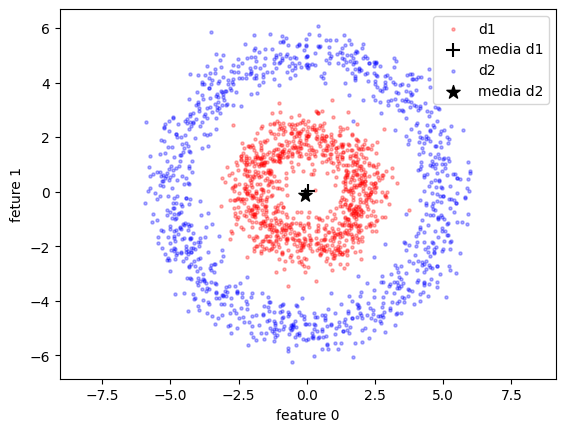

In [ ]:
plot_dataset(X2,y2)

# We now split the data.
## we will use a random selection
After remoring the test set we are going to perform the cross validation

In [ ]:
# Splitting data
from sklearn.model_selection import train_test_split
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.33, random_state=42)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.33, random_state=42)



In [ ]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
kf = KFold(n_splits=4)
for i,(train, vlidation) in enumerate(kf.split(X1_train)): # train, test are the indices for each fold
  print(" test size for fold {}  : {}".format(i,len(validation)))

 test size for fold 0  : 335
 test size for fold 1  : 335
 test size for fold 2  : 335
 test size for fold 3  : 335


In [ ]:
# we will wrap everything as a function so it is easier to analize the two datasets
def compare_accuracy(X1_train,y1_train):
  accuracyLR = []# create an array to store solutions
  accuracyKNN = []
  for i,(train, validation) in enumerate(kf.split(X1_train)):
    Xt = X1_train[train]
    Xv = X1_train[validation]
    yt = y1_train[train]
    yv = y1_train[validation]

    LR = LogisticRegression(random_state=0).fit(Xt, yt)
    KNN = KNeighborsClassifier(n_neighbors=5).fit(Xt, yt)

    predLR = LR.score(Xv,yv)
    predKNN = KNN.score(Xv,yv)

    accuracyLR.append(predLR)
    accuracyKNN.append(predKNN)

  print("LR : mean accuracy is {:1.3f} +/- {:1.3f}".format(np.mean(accuracyLR),np.std(accuracyLR)))
  print("KNN : mean accuracy is {:1.3f} +/- {:1.3f}".format(np.mean(accuracyKNN),np.std(accuracyKNN)))

  return accuracyLR, accuracyKNN



In [ ]:
accuracyLR, accuracyKNN  = compare_accuracy(X1_train,y1_train)

LR : mean accuracy is 0.999 +/- 0.001
KNN : mean accuracy is 0.999 +/- 0.001


In [ ]:
accuracyLR, accuracyKNN  = compare_accuracy(X2_train,y2_train)

NameError: ignored

# Exercise! (qui o a casa, a seconda di che ore sono)
- Perchè il classificatore lineare va bene per DATASET1 e non va bene per DATASET2?
- usare il codice di esercitazione 1 per fare il grafico della superficie di decisione nel caso di DATASET 2

# Come si può risolvere il problema di LR?
spesso una semplice trasformazione delle feature risolve il problema.
Applicare delle operazioni non lineari nello spazio delle feature permette ai classificatori non lineari di sfruttare relazioni a cui non hanno accesso naturalmente.

Che succede se usiamo il quadrato delle feature invece che la feature stessa?

In [ ]:
arr = np.array([2,4,8,16])# l0perazione potenza agisce su tutti gli elemnti

print(arr**2)

[  4  16  64 256]


In [ ]:
# be carefull that ^ is the XOR operator
print(1^1)
print(0^1)
print(1^0)
print(0^0)

0
1
1
0


LR : mean accuracy is 0.995 +/- 0.003
KNN : mean accuracy is 0.994 +/- 0.004


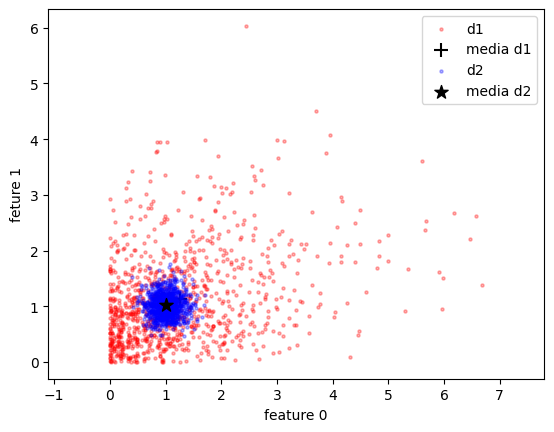

In [ ]:
plot_dataset(X2**2,y2)# netto a
accuracyLR, accuracyKNN  = compare_accuracy(X2_train**2,y2_train)

# We can try an experiment

In [ ]:
sigmas = np.linspace(0.3,3,30)
Ns = np.linspace(20,200,30).astype("int")

results = np.zeros((sigmas.shape[0],Ns.shape[0],2))

for i,s in enumerate(sigmas):
  for j, N in enumerate(Ns):
    X2,y2 = get_dataset_ball(N, sigma=s)
    accuracyLR, accuracyKNN = compare_accuracy(X2,y2)

    mLR = np.mean(accuracyLR)
    mKNN = np.mean(accuracyKNN)
    results[i,j,0] = mLR
    results[i,j,1] = mKNN


(40, 2)
(40,)
LR : mean accuracy is 0.975 +/- 0.043
KNN : mean accuracy is 0.975 +/- 0.043
(52, 2)
(52,)
LR : mean accuracy is 0.962 +/- 0.038
KNN : mean accuracy is 0.981 +/- 0.033
(64, 2)
(64,)
LR : mean accuracy is 0.984 +/- 0.027
KNN : mean accuracy is 0.984 +/- 0.027
(76, 2)
(76,)
LR : mean accuracy is 0.947 +/- 0.091
KNN : mean accuracy is 0.974 +/- 0.046
(88, 2)
(88,)
LR : mean accuracy is 0.989 +/- 0.020
KNN : mean accuracy is 0.989 +/- 0.020
(102, 2)
(102,)
LR : mean accuracy is 0.981 +/- 0.033
KNN : mean accuracy is 1.000 +/- 0.000
(114, 2)
(114,)
LR : mean accuracy is 0.965 +/- 0.042
KNN : mean accuracy is 0.965 +/- 0.024
(126, 2)
(126,)
LR : mean accuracy is 0.961 +/- 0.051
KNN : mean accuracy is 0.969 +/- 0.038
(138, 2)
(138,)
LR : mean accuracy is 0.971 +/- 0.035
KNN : mean accuracy is 0.971 +/- 0.035
(150, 2)
(150,)
LR : mean accuracy is 0.967 +/- 0.034
KNN : mean accuracy is 0.974 +/- 0.026
(164, 2)
(164,)
LR : mean accuracy is 0.988 +/- 0.012
KNN : mean accuracy is 0.9

Text(0, 0.5, 'sigma')

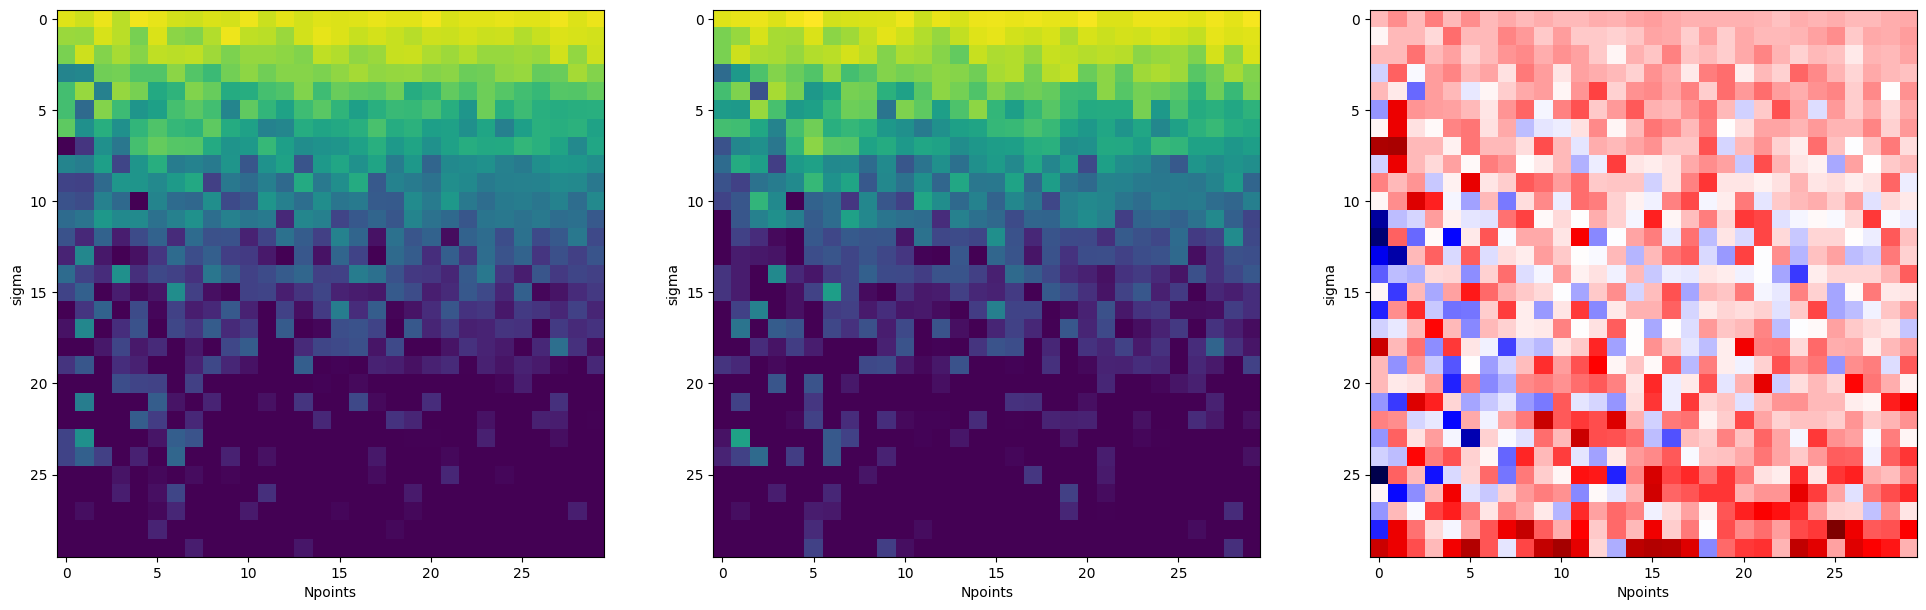

In [ ]:
f,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(24,8))
ax1.imshow(results[:,:,0],vmin=0.5,vmax=1)
ax1.set_xlabel("Npoints")
ax1.set_ylabel("sigma")

ax2.imshow(results[:,:,1],vmin=0.5,vmax=1)
ax2.set_xlabel("Npoints")
ax2.set_ylabel("sigma")

ax3.imshow(results[:,:,1]- results[:,:,0],cmap="seismic")
ax3.set_xlabel("Npoints")
ax3.set_ylabel("sigma")
